In [117]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
stops = stopwords.words('french')
import re
import matplotlib.pyplot as plt
from collections import Counter 
from IPython.display import display
import numpy as np

from keras.models import Sequential, Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Préparation data et présentation data

In [118]:
data = pd.read_csv('data/dataset_1.csv')
data=data.dropna()
data.head(2)

,Unnamed: 0,zip_code,problem,solution
0,1,57000,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...
1,5,95330,La pollution de l'air,En matière d'émission de C02 tout n'est pas di...


In [119]:
def zip_count(data):
    zip_counts =  Counter()
    for code in data['zip_code'].values:
        zip_counts[code]+=1
    df=pd.DataFrame({'zip_code': list(dict(zip_counts).keys()), 'freq': list(dict(zip_counts).values())})
    df=df.sort_values(by=['freq'],ascending=False)
    return df

In [160]:
df=zip_count(data)
z=[n//1000 for n in df['zip_code'].values]
df['dpt']=z
df.head(4)

,zip_code,freq,dpt
149,75015,85,75
469,75013,68,75
150,35000,67,35
190,75017,65,75


In [162]:
df['dpt'].values

array([75, 75, 35, ..., 63, 13, 42], dtype=int64)

In [170]:
def f(data):
    d=dict()
    for x in data['dpt'].values:
        d[str(x)]=0
        for k in range(len(data)):
            if data['dpt'].values[k]==x:
                d[str(x)]+=data['freq'].values[k]
    return d        


In [208]:
dictio=f(df)
dff=pd.DataFrame({'dpt': list(dictio.keys()), 'freq': list(dictio.values())})

In [209]:
dff=dff.sort_values(by=['freq'],ascending=False)
dff.head(3)

,dpt,freq
0,75,822
2,69,690
4,31,538


In [122]:
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
tokenizer.tokenize('je n\'sais pas !')

['je', "n'", 'sais', 'pas', '!']

In [127]:
#punctuation = re.compile('[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~]')
http = re.compile(r'http\S+')
www=re.compile(r'www.\S+')

from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
def text_prepare(text):
    text = text.lower() # min
    text=re.sub(r'<[^>]*>','',text)
    text=http.sub('', text) # suppr http...
    text=www.sub('',text) # suppr www...
#   text = punctuation.sub(' ', text) # suppr punct

    return text
    
def prepare_data2(dataset):
    problem=[]
    solution=[]
    zip_code=[]
    for k in range(dataset.shape[0]):
        problem.append(text_prepare(dataset['problem'].values[k]))
        solution.append(text_prepare(dataset['solution'].values[k]))
        zip_code.append(int(dataset['zip_code'].values[k]))        
    df=pd.DataFrame({'zip_code':zip_code, 'problem': problem, 'solution': solution})
    return df

In [128]:
data2=prepare_data2(data)

In [129]:
#afficher les mots dans la base de données avec leur nombre d'apparition

def word_num(dict):
    h=[]
    u=[]
    for x in dict.items():
        h.append(x[0])
        u.append(x[1])
    return h,u 
def word_count(data,s):
    tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
    lines=list(data['solution'])
    words_counts =  defaultdict(int)
    
    lines_T=[tokenizer.tokenize(line) for line in lines]
    for text in lines_T:
        for word in text:
            if s==False:
                if len(word)>1 : words_counts[word] += 1
            else:
                if len(word)>1 and word not in stops: words_counts[word] += 1
    word_filtered,num_filtered=word_num(words_counts)
    df= pd.DataFrame(num_filtered,index = word_filtered,columns = ['nombre'])
    df=df.sort_values(by=['nombre'],ascending=False)
    return df

In [130]:
stops[:10]

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle']

In [131]:
df=word_count(data2,False)    #FAlse on laisse les stopwords, True on les supprime
df.head()

,nombre
de,78810
les,59844
et,44624
des,40727
la,40655


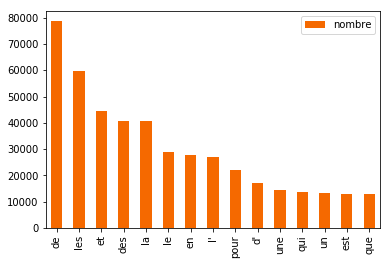

In [132]:
df[:15].plot(kind='bar', color="#f56900")

In [133]:
df2=word_count(data2,True)
df2.head()

,nombre
l',27213
d',17189
plus,12544
produits,5156
faire,5069


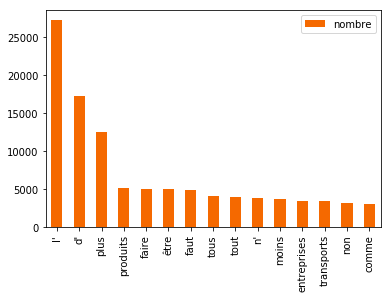

In [134]:
df2[:15].plot(kind='bar', color="#f56900")

In [135]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stops,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


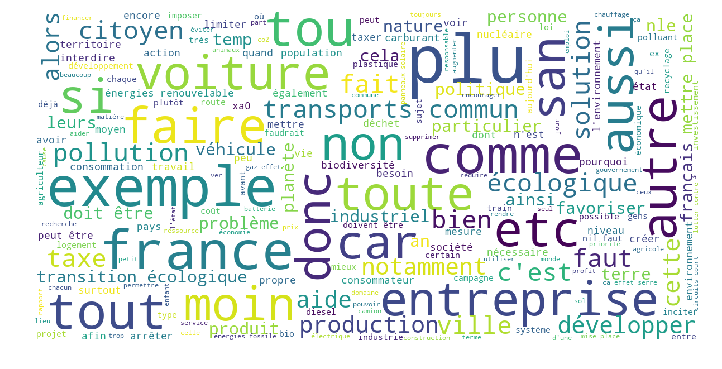

In [136]:
show_wordcloud(list(data2['solution']))

### Entrainement d'un model

In [137]:
data_train = pd.read_csv('data/data_F.csv', sep=';')
data_train.head(2)

,zip_code,problem,solution,annotation
0,57000,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,1.0
1,95330,La pollution de l'air,En matière d'émission de C02 tout n'est pas di...,1.0


In [138]:
def zip_count(data):
    zip_counts =  Counter()
    for code in data['zip_code'].values:
        zip_counts[code]+=1
    df=pd.DataFrame({'zip_code': list(dict(zip_counts).keys()), 'freq': list(dict(zip_counts).values())})
    df=df.sort_values(by=['freq'],ascending=False)
    return df


In [139]:
df=zip_count(data_train)
df.head(4)

,zip_code,freq
110,44000,15
149,75015,14
190,75017,13
147,75014,13


In [140]:
#punctuation = re.compile('[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~]')
http = re.compile(r'http\S+')
www=re.compile(r'www.\S+')

from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
def text_prepare(text):
    text = text.lower() # min
    text=re.sub(r'<[^>]*>','',text)
    text=http.sub('', text) # suppr http...
    text=www.sub('',text) # suppr www...
#   text = punctuation.sub(' ', text) # suppr punct

    return text
    
def prepare_data2(dataset):
    problem=[]
    solution=[]
    zip_code=[]
    annotation=[]
    for k in range(dataset.shape[0]):
        problem.append(text_prepare(dataset['problem'].values[k]))
        solution.append(text_prepare(dataset['solution'].values[k]))
        zip_code.append(int(dataset['zip_code'].values[k]))
        annotation.append(int(dataset['annotation'].values[k]))
        
    df=pd.DataFrame({'zip_code':zip_code, 'problem': problem, 'solution': solution, 'annotation':annotation })
    return df

In [141]:
data_train2=prepare_data2(data_train)

In [100]:
df=word_count(data_train2,False)    #FAlse on laisse les stopwords, True on les supprime
df[:15].plot(kind='bar', color="#f56900")

,nombre
de,12903
les,10117
et,7246
la,6655
des,6472


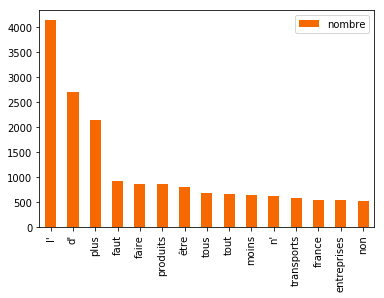

In [143]:
df2=word_count(data_train2,True)
df2[:15].plot(kind='bar', color="#f56900")

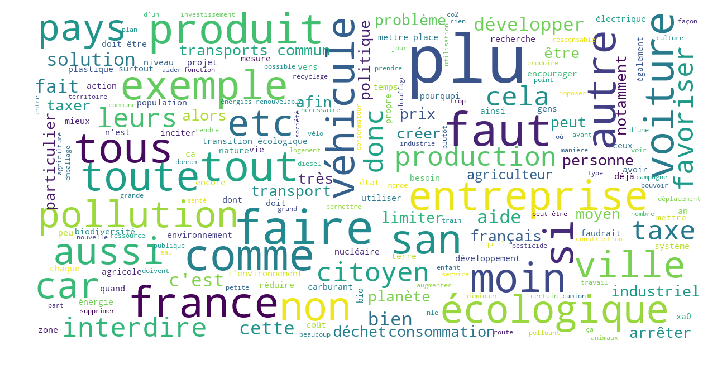

In [145]:
show_wordcloud(list(data_train2['solution']))

In [146]:
X, y = data_train2['solution'], data_train2['annotation']
from keras.utils import to_categorical
y_binary = to_categorical(y)

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [148]:
voc=word_count(data_train2,False)
len(voc)

16597

In [111]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer2 = Tokenizer(nb_words=20000, filters='\n',
                                   lower=True,split=' ')
tokenizer2.fit_on_texts(X_train)
X_train2 = tokenizer2.texts_to_sequences(X_train)
X_train2 = pad_sequences(X_train2)

X_test2 = tokenizer2.texts_to_sequences(X_test)
X_test2 = pad_sequences(X_test2,maxlen=X_train2.shape[1])

print(X_train2.shape,y_train_binary.shape)
print(X_test2.shape,y_test_binary.shape)

C:\Users\abdel\Anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(1955, 5105) (1955, 2)
(489, 5105) (489, 2)


In [112]:
embed_dim = 512
lstm_out = 128
batch_size = 32

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(20000, embed_dim,input_length = X_train2.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  if __name__ == '__main__':


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [113]:
hist=model.fit(X_train2, y_train_binary, validation_data=(X_test2,y_test_binary), batch_size = batch_size, verbose = 1, epochs=2)
score=max(hist.history['val_acc'])

Instructions for updating:
Use tf.cast instead.
Train on 1955 samples, validate on 489 samples
Epoch 1/2
1955/1955 [==============================] - 681s 349ms/step - loss: 0.5825 - acc: 0.7018 - val_loss: 0.5063 - val_acc: 0.7464
Epoch 2/2
1955/1955 [==============================] - 734s 376ms/step - loss: 0.3282 - acc: 0.8660 - val_loss: 0.7243 - val_acc: 0.5890


In [114]:
model.save('models/model.h5')

In [115]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test2, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test_binary, axis=1)
print(classification_report(y_test, y_pred_bool))

489/489 [==============================] - 27s 55ms/step
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       331
           1       0.42      0.69      0.52       158

   micro avg       0.59      0.59      0.59       489
   macro avg       0.60      0.62      0.58       489
weighted avg       0.67      0.59      0.60       489



In [151]:
def pred(data):
    X=data['solution'].values
    X = tokenizer2.texts_to_sequences(X)
    X = pad_sequences(X,maxlen=X_train2.shape[1])
    y_pred=model.predict(X, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    data['annotation']=y_pred
    return data

In [152]:
result=pred(data2)

15290/15290 [==============================] - 1149s 75ms/step


In [154]:
result.to_csv('data/result.csv', index=False, sep=';')

In [155]:
result.head(3)

,zip_code,problem,solution,annotation
0,57000,les problèmes auxquels se trouve confronté l’e...,les problèmes auxquels se trouve confronté l’e...,1
1,95330,la pollution de l'air,en matière d'émission de c02 tout n'est pas di...,1
2,84750,la biodiversité et la disparition de certaines...,"arrêter les pesticides , notamment le glyphosa...",1


In [210]:
dpts = [k for k in range(1,21)] + [20] + [k for k in range(21,96)]

def f(data):
    d=dict()
    for x in dpts:
        d[str(x)]=0
        for k in range(len(data)):
            if data['zip_code'].values[k]//1000==x:
                d[str(x)]+=data['annotation'].values[k]
    return d        


In [211]:
resultF=f(result)

In [214]:
df_result=pd.DataFrame({'dpt': list(resultF.keys()), 'freq': list(resultF.values())})
df_result=df_result.sort_values(by=['freq'],ascending=False)

In [225]:
df_result.index=df_result['dpt']
df_result.head(4)

,dpt,freq
dpt,,
75,75,382
69,69,353
13,13,256
78,78,252


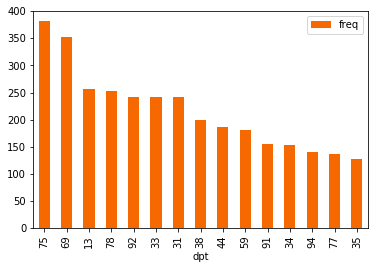

In [226]:
df_result[:15].plot(kind='bar', color="#f56900")
# a centrer dans la suite...

In [ ]:
import cartopy.crs as ccrs
import geoplot

dpts = [k for k in range(1,21)] + [20] + [k for k in range(21,96)]
Colors = list(df_result['freq'].values)
Colors = pd.DataFrame(Colors, index=list(df_result['dpt'].values), columns=['colors'])

plot_cartography(Colors, eval_type, figsize=(14,14))